### p-Hub median location problem

In [2]:
import math
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

In [3]:


def extract_parameters_from_excel(file_path):
    # Load sheets with specified names, skipping the ID and name columns/rows for matrices
    distance_df = pd.read_excel(file_path, sheet_name='Distance (km)').iloc[1:, 2:]
    travel_time_df = pd.read_excel(file_path, sheet_name='Travel time (min)').iloc[1:, 2:]
    flow_df = pd.read_excel(file_path, sheet_name='Flow').iloc[1:, 2:]
    fixed_link_cost_df = pd.read_excel(file_path, sheet_name='Fixed link cost').iloc[1:, 2:]
    fixed_hub_cost_df = pd.read_excel(file_path, sheet_name='Fixed hub cost').iloc[:, 2:]
    
    # Convert distance and travel time dataframes to matrices
    distance = distance_df.values
    travel_time = travel_time_df.values

    # Flow matrix: create nested dictionary to handle directional flow
    flow_matrix = flow_df.values   # Use iloc to get the first column's value for the flow

    # Fixed link cost: convert to matrix
    fixed_link_cost = fixed_link_cost_df.values

    # Fixed hub cost: extract city names and costs as a dictionary
    fixed_hub_cost = fixed_hub_cost_df.values


    return distance, travel_time, flow_matrix, fixed_link_cost, fixed_hub_cost


In [4]:
file_path = 'Turkish_network.xls'
distance, travel_time, flow_matrix, fixed_linked_cost, fixed_hub_cost = extract_parameters_from_excel(file_path)



In [5]:


def prune_and_sort_degrees(distance_matrix, r):
    # Initialize a fully connected graph from the distance matrix
    G = nx.Graph()
    num_nodes = len(distance_matrix)
    # Add nodes
    G.add_nodes_from(range(num_nodes))

    # Add edges only if the distance is less than or equal to r
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            distance = distance_matrix[i][j]
            if distance <= r:
                G.add_edge(i, j, weight=distance)

    # Get degrees and sort nodes by degree in descending order
    degree_dict = dict(G.degree())
    sorted_nodes_by_degree = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)

    return sorted_nodes_by_degree

# r = 1000
# sorted_nodes_by_degree = prune_and_sort_degrees(distance, r)


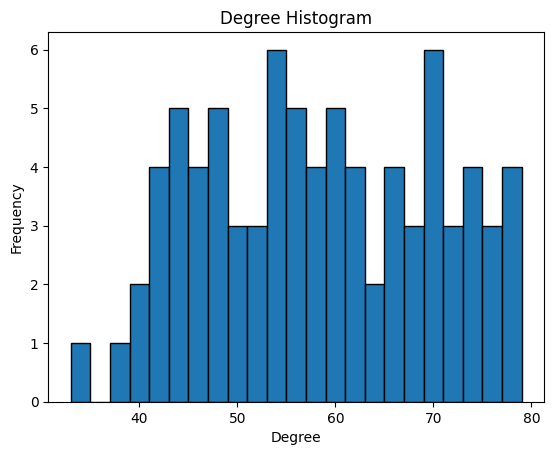

In [6]:
# Separate nodes and degrees for plotting
r = 1000
sorted_nodes_by_degree = prune_and_sort_degrees(distance, r)
nodes, degrees = zip(*sorted_nodes_by_degree)

# Define a custom bin width
bin_width = 2  # Change this value to adjust the width of bins
bins = range(min(degrees), max(degrees) + bin_width, bin_width)

# Plotting the degree histogram with wider bins
plt.hist(degrees, bins=bins, edgecolor='black', align='left')

# Adding labels and title
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Histogram')

# Show the plot
plt.show()

In [6]:
def select_active_hubs(distance_matrix, r, cutoff):

    sorted_nodes_by_degree= prune_and_sort_degrees(distance_matrix, r)
    # Separate nodes and degrees for processing
    nodes, degrees = zip(*sorted_nodes_by_degree)

    # Find the index where the degree becomes smaller than the cutoff
    cutoff_index = next((i for i, degree in enumerate(degrees) if degree < cutoff), None)

    # Output the index and the degree at that index
    # print(f"Index where degree is smaller than {cutoff}: {cutoff_index}")
    active_nodes = nodes[:cutoff_index]
    return active_nodes

In [22]:
# Define range for cutoff
r = 1000
# Define the cutoff value
cutoff = 71

active_nodes = select_active_hubs(distance, r, cutoff)
print(len(active_nodes))
active_nodes


16


(4, 37, 49, 65, 18, 39, 59, 50, 54, 67, 79, 70, 0, 57, 32, 36)

In [ ]:
def find_hubs(I, f, u, d, flows, hubcosts, r = 1000, cutoff = 69, alpha = 0.5, verbose_y = False, write_down = False, time = 1):

        """
        I: set of hubs
        f: fixed operating cost for open routes equal to 0
        u: unit cost per km per kg
        d: distances
        flows: required flow from i to j
        hubcosts: costs to open hubs
        r: connection cutoff range forhigh-connection
        cutoff: number of connections needed to be a candidate
        alpha: interhub transfer discount 
        """
        hubs = []
        

        #fixed_hub_cost = {...}  # Dictionary of fixed costs
        u = np.array(u)
        f = np.array(flows)

        # Step 1: Select candidate hubs (e.g., lowest fixed costs)
        H = select_active_hubs(d, r, cutoff) #defining active nodes for hub locations
        #H = (44,25,39,43,11)
        n = len(H)
        
        print("Number of hubs",n)
        print("Number of cities", I.shape[0])
        # Step 2: Define Model
        model = gp.Model("Hub Location")

        # Decision variables
        x = model.addVars([(k) for k in H], vtype=GRB.BINARY, name="x_k")  # Hub indicator for candidates
        y_ijkl = model.addVars([(i, j, k, l) for i in I for j in I for k in H for l in H if i != j], vtype=GRB.CONTINUOUS, name="y", lb=0)  # Flow variables

        u_ijkl = {(i, j, k, l): d[i, k] + alpha * d[k, l] + d[l, j]
          for i in I for j in I for k in H for l in H if i != j}
        # Objective: Minimize total transportation and hub setup costs

        model.setObjective(
           gp.quicksum(u_ijkl[i, j, k, l] * f[i, j] * y_ijkl[i, j, k, l]
                for i in I for j in I for k in H for l in H if i != j),
                GRB.MINIMIZE
                )

        # Constraint: Total budget for hubs
        model.addConstr(gp.quicksum(x[i] * hubcosts[i] for i in H) <= 2400, name="hub_total_cost")

        # Flow sum constraints: sum over all hub pairs for each (i, j) should equal 1
        model.addConstrs(
                        (gp.quicksum(y_ijkl[i, j, k, l] for k in H for l in H) == 1 
                        for i in I for j in I if i != j),
                        name="connectedness"
                        )

        # y less than x_k
        model.addConstrs((y_ijkl[i, j, k, l] <= x[k] for i in I for j in I for k in H for l in H if i != j), name="hub_upper")

        # y less than x_l
        model.addConstrs((y_ijkl[i, j, k, l] <= x[l] for i in I for j in I for k in H for l in H if i != j), name="hub_lower")

        # Display the model's details in the console
        #print(model)

        # Set model solve time limit
        model.setParam('TimeLimit', time*60)

        # Display the problem in LP format
        if write_down:
                model.write("heuristic_hub_location_model.lp")
                print("\n MODEL IS WRITTEN \n")
        else:
                print("\n Model is not stored \n")


        reduced_model = model.presolve()
        reduced_model.write("reduced_model.mps")
        return

       

In [17]:
def Solver(I, f, u, d, flows, hubcosts, r = 1000, cutoff = 69, alpha = 0.5, verbose_y = False, write_down = False, time = 1):
    hubs = []
    model = gp.read("reduced_model.mps")  

    # Set model solve time limit
    model.setParam('TimeLimit', time*60)
     # Solve model
    model.optimize()

    # Display Results
    for v in model.getVars():
            if v.varName.startswith("x") and v.x > 0.5:
                    print(f"Hub selected at: {v.varName}")
                    index = int(v.varName.split("[")[1].strip("]"))
                    hubs.append(index)  # Collecting the index only
            elif v.varName.startswith("y") and v.x > 0.1 and verbose_y == 1:
                    print(f"y: {v}")

    for i in range(model.SolCount):
            model.Params.SolutionNumber = i
            model.write(f"{i}.sol")


    return hubs, model.objVal

In [23]:
# Define range for cutoff
r = 1000
# Define the cutoff value
cutoff = 71
# Define interhub transfer discount 
alpha = 0.5
n = 81
#u = np.full((81, 81), 1e-4)
u = fixed_linked_cost * 1e-3
I = np.arange(0,n)
fixed_linkage_costs =np.zeros((n,n))
# hubs, min_cost, var = 
find_hubs(I, fixed_linkage_costs, u, distance, flow_matrix, fixed_hub_cost, r, cutoff, alpha, write_down = False, verbose_y = False)

Number of hubs 16
Number of cities 81


C:\Users\DELL-G15-5479\AppData\Local\Temp\ipykernel_2012\2753522384.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  model.addConstr(gp.quicksum(x[i] * hubcosts[i] for i in H) <= 2400, name="hub_total_cost")


Set parameter TimeLimit to value 60

 Model is not stored 

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Presolve removed 103680 rows and 0 columns (presolve time = 5s) ...
Presolve removed 103680 rows and 0 columns (presolve time = 10s) ...
Presolve removed 206488 rows and 51404 columns (presolve time = 15s) ...
Presolve removed 206488 rows and 51404 columns (presolve time = 20s) ...
Presolve removed 206488 rows and 51404 columns (presolve time = 25s) ...
Presolve removed 206488 rows and 51404 columns
Presolve time: 25.02s


In [24]:
Solver(I, fixed_linkage_costs, u, distance, flow_matrix, fixed_hub_cost, r, cutoff, alpha, write_down = True, verbose_y = False, time = 60)


Read MPS format model from file reduced_model.mps
Reading time = 8.76 seconds
Hub: 3117753 rows, 1607492 columns, 7830036 nonzeros
Set parameter TimeLimit to value 3600
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3117753 rows, 1607492 columns and 7830036 nonzeros
Model fingerprint: 0x86e68a2a
Variable types: 1607476 continuous, 16 integer (16 binary)
Coefficient statistics:
  Matrix range     [5e-01, 7e+02]
  Objective range  [5e+04, 2e+09]
  Bounds range     [5e-01, 1e+00]
  RHS range        [1e+00, 2e+03]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 0 rows and 0 columns (presolve time = 5s) ...
Presolve removed 0 rows and 0 columns (presolve time = 10s) ...
Presolve time: 12.22s
Preso

([79, 70, 57], 60082576650.04974)

The solution found is 80, 71, 57